# Analizando datos del covid19 con Python

## Introducción

Fuente: https://pomber.github.io/covid19/timeseries.json

Advertencia: Nada de esto es científico, no me dedico a nada que tenga que ver con salud, aunque tengo estudios en el área hace ya más de 1 década que no hago nada que tenga que ver ni parcialmente con ello, así que simplemente es un proceso de auto complacencia para tratar de ver los números que están disponibles, todo lo que digo es mi opinión, y seguro estoy comentiendo errores de análisis, de código y de juicio. Los datos siempre van un día atrasados porque la fuente así se actualiza.

Es probable que vaya actualizando mis opiniones y el código, gráficas, etc. Pero de ninguna manera es algo que esté haciendo de manera profesional o seria, si sirve de algo me daría mucho gusto, por el momento solo sirve para darme idea de cómo va México en el proceso, y espero que las decisiones que se han ido tomando nos mantengan entre los países con menores daños en esta epidemia, la primera fuerte que vive mi generación ! esto va a ser algo para recordar. Hemos tenido diversas enfermedados en las últimas décadas que han dado problemas serios (SIDA, SARS, Ébola, MERS, y seguro otras que no recuerdo en este momento), pero creo que el covid19 va a pasar a la historia como la peor de esta época, una epidema de las que se dan cada 100 años o incluso con menor frecuencia.

Sobre el código, tratando de sacarle provecho a todo lo posible (en las bibliotecas de python) para hacer el análisis más sencillo (menos código) uso en la mayor parte de las gráficas las herramientas de Pandas, y trato de no usar demasiado matplotlib por fuera, claro que no es posible al 100% ni cerca, pero intento. 

Lo que sigue es un montón de imports de las herramientas más populares de analisis y graficado de datos:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as r
import matplotlib.dates as mdates
import time
from IPython.display import clear_output
from time import sleep
from scipy.optimize import curve_fit
import statsmodels.api as sm
import matplotlib.colors as mcolors
import json

# Descargando la fuente de datos

`requests` es una de las bibliotecas más fáciles de usar para interaccionar con sitios web de manera genérica o para recolectar datos (APIs, JSON, Tablas, etc.).

In [2]:
data = r.get("https://pomber.github.io/covid19/timeseries.json")
#data.json()

## Países en el archivo

In [3]:
print("{} países registrados con al menos 1 caso confirmado:\n".format(len(data.json().keys())))

for i in data.json().keys():
    print("{}, ".format(i), end="")

185 países registrados con al menos 1 caso confirmado:

Afghanistan, Albania, Algeria, Andorra, Angola, Antigua and Barbuda, Argentina, Armenia, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Brazil, Brunei, Bulgaria, Burkina Faso, Cabo Verde, Cambodia, Cameroon, Canada, Central African Republic, Chad, Chile, China, Colombia, Congo (Brazzaville), Congo (Kinshasa), Costa Rica, Cote d'Ivoire, Croatia, Diamond Princess, Cuba, Cyprus, Czechia, Denmark, Djibouti, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, Estonia, Eswatini, Ethiopia, Fiji, Finland, France, Gabon, Gambia, Georgia, Germany, Ghana, Greece, Guatemala, Guinea, Guyana, Haiti, Holy See, Honduras, Hungary, Iceland, India, Indonesia, Iran, Iraq, Ireland, Israel, Italy, Jamaica, Japan, Jordan, Kazakhstan, Kenya, Korea, South, Kuwait, Kyrgyzstan, Latvia, Lebanon, Liberia, Liechtenstein, Lithuania, Luxembourg, Ma

## Copiando los datos a un Data Frame para facilidad de manejo
Se guarda un diccionario de datos con los datos de cada país en forma de DataFrame y se hace un diccionario del total de casos para cada día registrado en la fuente:

In [4]:
total = {}
country = {}
for k in data.json().keys():
    #print(k)
    country[k] = pd.DataFrame.from_dict(data.json()[k], )
    country[k]['date'] = pd.to_datetime(country[k]['date'])
    country[k].index = country[k]['date'] 
    del country[k]['date'] 
    for item in data.json()[k]:
        if item['date'] in total:
            total[item['date']][0] += item['confirmed']
            total[item['date']][1] += item['deaths']
            total[item['date']][2] += item['recovered']
        else:
            total[item['date']] = [item['confirmed'], item['deaths'], item['recovered']]
print(total)

{'2020-1-22': [555, 17, 28], '2020-1-23': [654, 18, 30], '2020-1-24': [941, 26, 36], '2020-1-25': [1434, 42, 39], '2020-1-26': [2118, 56, 52], '2020-1-27': [2927, 82, 61], '2020-1-28': [5578, 131, 107], '2020-1-29': [6166, 133, 126], '2020-1-30': [8234, 171, 143], '2020-1-31': [9927, 213, 222], '2020-2-1': [12038, 259, 284], '2020-2-2': [16787, 362, 472], '2020-2-3': [19881, 426, 623], '2020-2-4': [23892, 492, 852], '2020-2-5': [27635, 564, 1124], '2020-2-6': [30794, 634, 1487], '2020-2-7': [34391, 719, 2011], '2020-2-8': [37120, 806, 2616], '2020-2-9': [40150, 906, 3244], '2020-2-10': [42762, 1013, 3946], '2020-2-11': [44802, 1113, 4683], '2020-2-12': [45221, 1118, 5150], '2020-2-13': [60368, 1371, 6295], '2020-2-14': [66885, 1523, 8058], '2020-2-15': [69030, 1666, 9395], '2020-2-16': [71224, 1770, 10865], '2020-2-17': [73258, 1868, 12583], '2020-2-18': [75136, 2007, 14352], '2020-2-19': [75639, 2122, 16121], '2020-2-20': [76197, 2247, 18177], '2020-2-21': [76819, 2251, 18890], '2020-

El arreglo de datos totales se pasa a DataFrame también y se agregan un par de columnas utilitarias que nos ayudarán a trabajar con ajustes en las siguientes celdas. Adelantando un poco de información, las fechas no son buenos datos para usar en un ajuste, el tiempo lo es, pero usar el epoch (número de segudos desde 1970-01-01 hasta el momento deseado) nos da números de magnitudes enormes que no son fáciles de manejar en algunos tipos de ajustes, particularmente los de crecimiento exponencial, por lo que podemos hacer una pequeña transformación de segundos a días y con eso tener números mucho más pequeños y fáciles de visualizar y manejar.

In [5]:
total_df = pd.DataFrame.from_dict(total, orient="index", columns=['confirmed', 'deaths', 'recovered'])
total_df.index = pd.to_datetime(total_df.index)
min_sec = time.mktime(total_df.index.min().timetuple())
total_df['seconds'] = [time.mktime(t.timetuple()) - min_sec for t in total_df.index]
total_df['days'] = total_df['seconds'] / 86400
total_df.head() # Ver la forma del DF

,confirmed,deaths,recovered,seconds,days
2020-01-22,555,17,28,0.0,0.0
2020-01-23,654,18,30,86400.0,1.0
2020-01-24,941,26,36,172800.0,2.0
2020-01-25,1434,42,39,259200.0,3.0
2020-01-26,2118,56,52,345600.0,4.0


In [6]:
total_df.diff().tail()

,confirmed,deaths,recovered,seconds,days
2020-04-13,70117.0,5391.0,26933.0,86400.0,1.0
2020-04-14,71353.0,6502.0,25606.0,86400.0,1.0
2020-04-15,79863.0,8193.0,36758.0,86400.0,1.0
2020-04-16,96592.0,9624.0,31088.0,86400.0,1.0
2020-04-17,87544.0,10021.0,26236.0,86400.0,1.0


# Números totales
Analizando la evolución de los números globables.

In [73]:
total_df.query("confirmed >= 1000000 and confirmed <= 2000000").head()

,confirmed,deaths,recovered,seconds,days,poly
2020-04-02,1013466,52983,210263,6134400.0,71.000000,9.944837e+05
2020-04-03,1095917,58787,225796,6220800.0,72.000000,1.068545e+06
2020-04-04,1176060,64606,246152,6307200.0,73.000000,1.145083e+06
2020-04-05,1249754,69374,260012,6393600.0,74.000000,1.223925e+06
2020-04-06,1321481,74565,276515,6476400.0,74.958333,1.301463e+06


In [74]:
total_df.query("confirmed >= 1000000 and confirmed <= 2000000").tail()

,confirmed,deaths,recovered,seconds,days,poly
2020-04-10,1657526,102525,376096,6822000.0,78.958333,1.641381e+06
2020-04-11,1735650,108502,402110,6908400.0,79.958333,1.729073e+06
2020-04-12,1834721,114090,421722,6994800.0,80.958333,1.817199e+06
2020-04-13,1904838,119481,448655,7081200.0,81.958333,1.905383e+06
2020-04-14,1976191,125983,474261,7167600.0,82.958333,1.993223e+06


In [75]:
total_df.tail(1)

,confirmed,deaths,recovered,seconds,days,poly
2020-04-17,2240190,153821,568343,7426800.0,85.958333,2.250206e+06


Pasamos el millón de casos en 2 de abril, y pasamos los 2 millones de casos 13 días después el 15 de abril, actualmente tenemos casi 2.25 millones solo 2 días después, por lo que la situación es algo preocupante, a este paso en 6 días más (8 en total) estaríamos pasando los 3 millones, y estaríamos duplicando los 2 millones para llegar a 4 millones en aproximadamente 16 días, lo cual implicaría que seguimos en crecimiento bastante acelerado de casos, el número de decesos incluso va más acelerado, lo que para mi indica que los gobiernos necesitan continuar con medidas igual o más restrictivas que las que están usando actualmente, creo que todavía no es tiempo de aflojar.


# Ajustes
Esta es la evolución de los datos globales (22 de enero 2020 a la fecha) con un ajuste de crecimiento exponencial sobrepuesto hecho con la API de `statsmodels`.

## Ajuste exponencial
Los ajustes usan la columna de día como abscisa (x) tomando como día cero en 2020-01-22 que es el inicio de los datos.

In [7]:
# Definir datos a ajustar con statsmodels.OLS
x_range = total_df.days
y_range = np.log(total_df["confirmed"]) # Log del exponencial para hacer un ajuste lineal
# Los ingresamos al ajustador de mínimos cuadrados
X = sm.add_constant(x_range)
y = y_range
mods = sm.OLS(y, X)
res = mods.fit()

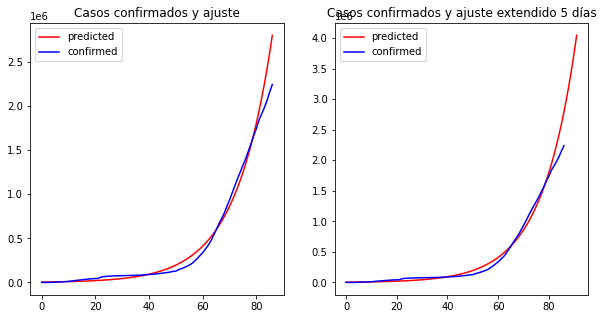

In [8]:
# Extraer parámetros resultantes y  sustituírlos adecuadamente
a, b = res.params
y = lambda x: np.exp(a) * np.exp(b) ** x # Usamos lambdas !
x_predicted = np.linspace(total_df.days.min(), total_df.days.max(), len(total_df.days))
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x_predicted, y(x_predicted), 'r-', label="predicted")
ax[0].plot(total_df.days, total_df['confirmed'], 'b-', label="confirmed")
# Predicción con 5 días en el futuro
x_predicted = np.linspace(total_df.days.min(), total_df.days.max()+5, len(total_df.days))
ax[1].plot(x_predicted, y(x_predicted), 'r-', label="predicted")
ax[1].plot(total_df.days, total_df['confirmed'], 'b-', label="confirmed")
# Títulos
ax[0].set_title("Casos confirmados y ajuste")
ax[1].set_title("Casos confirmados y ajuste extendido 5 días")
# Fix labels
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.legend()


Esta es una de las primeras gráficas que quería ver, de hecho con esto inicié el notebook, y rápidamente me di cuenta que aunque estamos en una buena etapa para ajustar los datos con una ecuación simple de crecimiento exponencial, es obvio que hay mucho ruido tanto de las fuentes de datos como del comportamiento no ideal del bicho. 

La segunda gráfica es la predicción con 5 días en el futuro, la empecé a ver cuando el número de casos era de unos 300 mil creo, llegar al millón se veía a un par de semanas. Eventualmente pasamos el millón y creo que 13 días después llegamos a los 2 millones el día de hoy (15-04-2020).

Veo con un poco de optimismo que la curva parece empezar apenas a "aplanarse", estoy casi seguro que en unos días ya va a ser evidente que ya no aplica la exponencial y se requiere un método más complicado para describir el comportamiento, eso significa que tengo que trabajar en ello !!

La siguiente gráfica es "la derivada numérica de los datos", en otras palabras la diferencia de casos confirmados entre cada día.

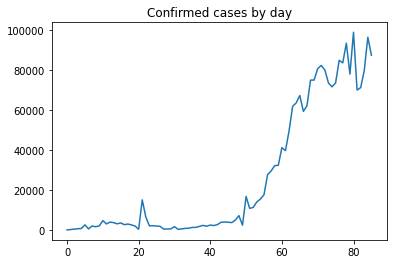

In [9]:
plt.plot(np.diff(total_df.confirmed))
_ = plt.title("Confirmed cases by day")

El pico al rededor del día 20 lo explican como una corrección (o cambio) del método de detección del virus en China, me parece que algo similar pasó por el día 50, pero no estoy seguro de eso. 

Hay un nuevo salto al día 75 (aprox.), pareciera que cada 20-30 días hay algo así, algún tipo de corte se hace a nivel mundial seguramente, pero habrá que ver si se sigue presentando.

Después del día 50 creo que podemos decir que la epidemia ya está comprobada, el número de casos nuevos cada día es enorme, ya tenemos varios días (10 o más) sin aumentar de manera exponencial el número de nuevos casos lo cual coincide con lo que comentaba antes. Necesito agregar la misma gráfica para decesos, veamos:



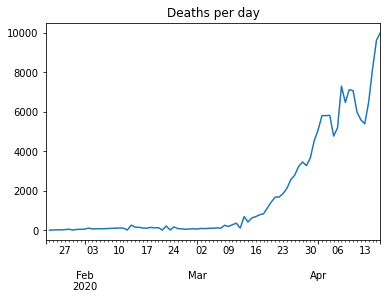

In [10]:
total_df.deaths.diff().plot(title="Deaths per day") # otra forma de hacer lo mismo que arriba

Al parecer sí estamos llegando a la etapa de estabilizar la epidemia, al menos a nivel global parece que sí está funcionando todo el esfuerzo (13 de abril). Probablemente en una semana podremos confirmar esto, necesitamos principalmente que esta gráfica sea claramente aplanada para sentirnos con confianza.

Es temprano todavía, pero al 17 de abril las cosas no se ven tan bien, hay que esperar unos días para ver si vuelven a bajar los números en esta gráfica, esperemos que sí, es muy buen indicador de la efectividad de las medidas de contención.

## Ajuste polinomial
Esta es la segunda gráfica que hice al darme cuenta que los números no se ajustan de manera "maravillosa" a la exponencial. 

Decidí hacer un ajuste simple polinomial (NumPy al rescate) que obviamente se ve mucho mejor en general, pero no solo eso, a simple vista se puede ver que su predicción es probablemente más acertada también (aunque sea de pura casualidad, planeo probar eso en los siguientes días haciendo ajustes obre los datos parciales y viendo cómo reproducen "el futuro" digamos de 1 o 2 semanas (las últimas registradas).

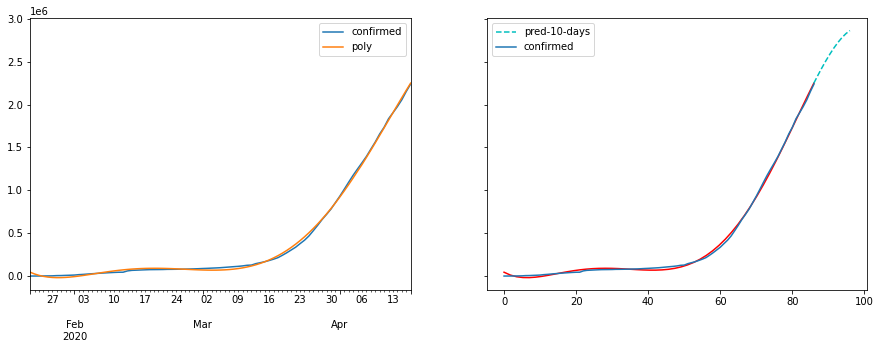

In [11]:
p = np.polyfit(total_df["days"].array, total_df["confirmed"].array,5) # 5to grado
x = np.linspace(total_df.days.min(), total_df.days.max(),50)
f = np.poly1d(p)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,5))

total_df['poly'] = f(total_df.days) #Agregando el ajuste al DF
total_df.plot( y=["confirmed", "poly"], fig=fig, ax = ax1)
x = np.linspace(total_df.days.min(), total_df.days.max(),50)
ax2.plot(x, f(x), 'r-')
x = np.linspace(total_df.days.max(), total_df.days.max()+10,10)
ax2.plot(x, f(x), 'c--', label='pred-10-days')
ax2.plot(range(total_df["confirmed"].count()), total_df["confirmed"], label='confirmed')
leg = ax2.legend()

Ya llegamos al punto en el que tanto el ajuste exponencial como polinomial no son realmente buena opción, hoy cambié el orden del polinomio ajustado de 4 a 5 porque ya no ajustaba tan bien, y si uso 6 es obvio el sobre ajuste.

Por segunda vez voy a guardar la predicción de hoy (2020-04-15) para ver dentro de 10 días que tan exacta eso, deberíamos tener 2 millones 800 mil casos según la predicción. Veremos en 10 días.

In [12]:
f(total_df.days), f(x)

(array([ 4.50433608e+04,  2.43883466e+04,  8.45905384e+03, -3.27591106e+03,
        -1.13159803e+04, -1.61293935e+04, -1.81539668e+04, -1.77978613e+04,
        -1.54403525e+04, -1.14325985e+04, -6.09840945e+03,  2.64984093e+02,
         7.38616194e+03,  1.50187456e+04,  2.29406293e+04,  3.09532113e+04,
         3.88806250e+04,  4.65689697e+04,  5.38855424e+04,  6.07180684e+04,
         6.69739328e+04,  7.25794113e+04,  7.74789018e+04,  8.16341551e+04,
         8.50235061e+04,  8.76411053e+04,  8.94961496e+04,  9.06121136e+04,
         9.10259805e+04,  9.07874736e+04,  8.99582874e+04,  8.86113182e+04,
         8.68298962e+04,  8.47070157e+04,  8.23445667e+04,  7.98525661e+04,
         7.73483888e+04,  7.49559986e+04,  7.28051795e+04,  7.10307670e+04,
         6.97718791e+04,  6.91711474e+04,  6.93739481e+04,  7.05276337e+04,
         7.27807635e+04,  7.62823351e+04,  8.11810154e+04,  8.76243720e+04,
         9.57581039e+04,  1.05725273e+05,  1.17665535e+05,  1.31714371e+05,
         1.4

In [13]:
#Ajuste + predicción
pred_2020_04_15_fit = [ 4.77119872e+04,  2.59628868e+04,  9.14389100e+03, -3.29769039e+03,
        -1.18813736e+04, -1.70942995e+04, -1.93920314e+04, -1.91993540e+04,
        -1.69110713e+04, -1.28928048e+04, -7.48179236e+03, -9.87685741e+02,
         6.30665047e+03,  1.41443408e+04,  2.22937007e+04,  3.05474379e+04,
         3.87218544e+04,  4.66560482e+04,  5.42111147e+04,  6.12693486e+04,
         6.77334456e+04,  7.35257042e+04,  7.85872268e+04,  8.28771224e+04,
         8.63717074e+04,  8.90637078e+04,  9.09614604e+04,  9.20881154e+04,
         9.24808370e+04,  9.21900059e+04,  9.12784206e+04,  8.98204992e+04,
         8.79014812e+04,  8.56166291e+04,  8.30704299e+04,  8.03757973e+04,
         7.76532727e+04,  7.50302276e+04,  7.26400648e+04,  7.06214204e+04,
         6.91173652e+04,  6.82746067e+04,  6.82426906e+04,  6.91732026e+04,
         7.12189699e+04,  7.45332632e+04,  7.92689980e+04,  8.55779370e+04,
         9.36098908e+04,  1.03511920e+05,  1.15427538e+05,  1.29495911e+05,
         1.45851061e+05,  1.64621065e+05,  1.85927260e+05,  2.09883445e+05,
         2.36595077e+05,  2.66158481e+05,  2.98660044e+05,  3.34175421e+05,
         3.72768738e+05,  4.14491788e+05,  4.59383238e+05,  5.07467829e+05,
         5.58755577e+05,  6.13240975e+05,  6.70902196e+05,  7.31700293e+05,
         7.95578401e+05,  8.62460939e+05,  9.32252812e+05,  1.00483861e+06,
         1.08008182e+06,  1.15782401e+06,  1.23788405e+06,  1.31659412e+06,
         1.40057801e+06,  1.48620321e+06,  1.57319086e+06,  1.66123546e+06,
         1.75000401e+06,  1.83913526e+06,  1.92823893e+06,  2.01689483e+06,
         2.10465215e+06]
pred_2020_04_15_10_days = [2104652.14542556, 2200518.71336595, 2293971.40903023,
        2384251.39340409, 2470547.96356723, 2551997.20075698,
        2627680.61843207, 2696623.81033628, 2757795.0985621 ,
        2810104.18161445]

In [14]:
total_df["confirmed"].count()

87

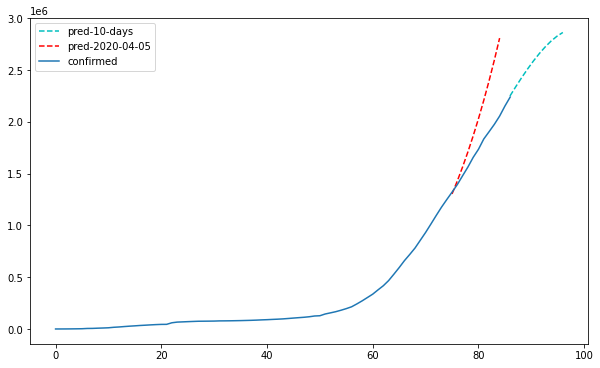

In [15]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(10,6))
ax.plot(x, f(x), 'c--', label='pred-10-days')
ax.plot(range(75, 75+10), [1304635.15176798, 1430442.28829449, 1565539.96742723,
        1710362.7715662 , 1865354.81842985, 2030969.76105508,
        2207670.78779722, 2395930.62233004, 2596231.52364578,
        2809065.28605508], 'r--', label='pred-2020-04-05')
ax.plot(range(total_df["confirmed"].count()), total_df["confirmed"], label='confirmed')
leg = ax.legend()

Vemos la predicción a 10 días completa (rojo) alejándose de lo que sucedió realmente, esto también parece el inicio de una nueva etapa, empiezo a sentirme ligeramente más tranquilo al respecto de todo esto.

Y vemos ahora la curva para los próximos 10 días con el ajuste orden 5.

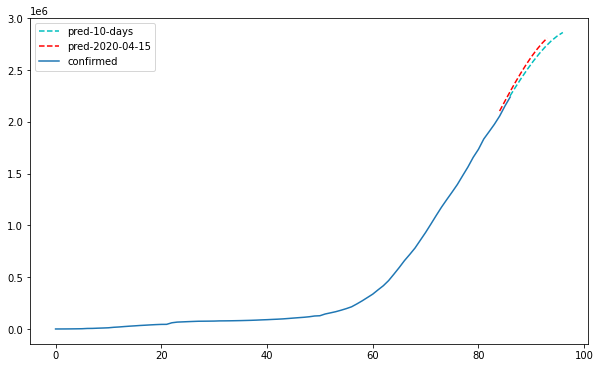

In [16]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(10,6))
ax.plot(x, f(x), 'c--', label='pred-10-days')
ax.plot(range(84, 84+10), [2104652.14542556, 2200518.71336595, 2293971.40903023,
        2384251.39340409, 2470547.96356723, 2551997.20075698,
        2627680.61843207, 2696623.81033628, 2757795.0985621 ,
        2810104.18161445], 'r--', label='pred-2020-04-15')
ax.plot(range(total_df["confirmed"].count()), total_df["confirmed"], label='confirmed')
leg = ax.legend()

Y veremos cómo se ve dentro de 10 días.

## Decesos y recuperados
Posiblemente los números de decesos sean los mas exactos que se tienen al respecto de las 3 variables en este dataset, y obviamente la más preocupante, el número de muertes ha ido en aumento en casi todos los países, excepciones son China y Corea del Sur, esperemos que otros países logren controlar la epidemia pronto.

Hay un post en Medium (luego pongo la liga) que hipotetiza que en realidad es probable que el número de decesos sea 1/5 del real, han comparado el número de decesos anuales contra el número actual en algunas entidades y eso dice que se observa, veremos al final del año con las cifras del INEGI en México, va a ser algo fácil de detectar.

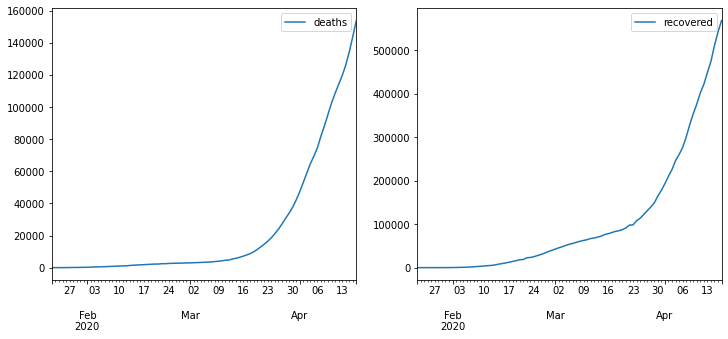

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
total_df.plot( y=["deaths"], ax=ax[0])
total_df.plot( y=["recovered"], ax=ax[1])

Afortunadamente el número de casos recuperados va a la alza, y el números de decesos no parece ir tan rápido como el de casos confirmados

## Países con más casos (min_confirmed=5000)

Ahora vamos a expulgar un poco más, tomamos el registro más reciente de cada país filtrando los que tienen más de `min_confirmed` casos confirmados para tener el total de cada país:

In [18]:
min_confirmed = 5000
day = country['Mexico'].index[-1].strftime("%Y-%m-%d") # Last day for any of the countries
print(day)
country_day = {}
for k in data.json().keys():
    country_day[k] =  country[k].loc[day]#["confirmed"]

2020-04-17


Pasamos el diccionario a un DataFrame para graficar fácilmente los datos (vamos a usar ese truco casi en todos los casos):

In [19]:
country_day = pd.DataFrame.from_dict(country_day, orient='index', columns=["confirmed", "recovered", "deaths"])

In [20]:
country_day.head()

,confirmed,recovered,deaths
Afghanistan,906,99,30
Albania,539,283,26
Algeria,2418,846,364
Andorra,696,191,35
Angola,19,5,2


In [21]:
country_day.sort_values("confirmed", ascending=False).head(20)

,confirmed,recovered,deaths
US,699706,58545,36773
Spain,190839,74797,20002
Italy,172434,42727,22745
France,149130,35006,18703
Germany,141397,83114,4352
United Kingdom,109769,394,14607
China,83760,77552,4636
Iran,79494,54064,4958
Turkey,78546,8631,1769
Belgium,36138,7961,5163


Estados Unidos tiene ahora más del triple de casos que Italia que van en segundo lugar y el cerca del 30% de los casos mundiales, nada mal !

In [22]:
country_day.sum()

confirmed    2240190
recovered     568343
deaths        153821
dtype: int64

## Número de países con muchos casos (*más* de `4000` casos confirmados):

Y su distribución por porcentajes, disculpen el traslape de etiquetas:

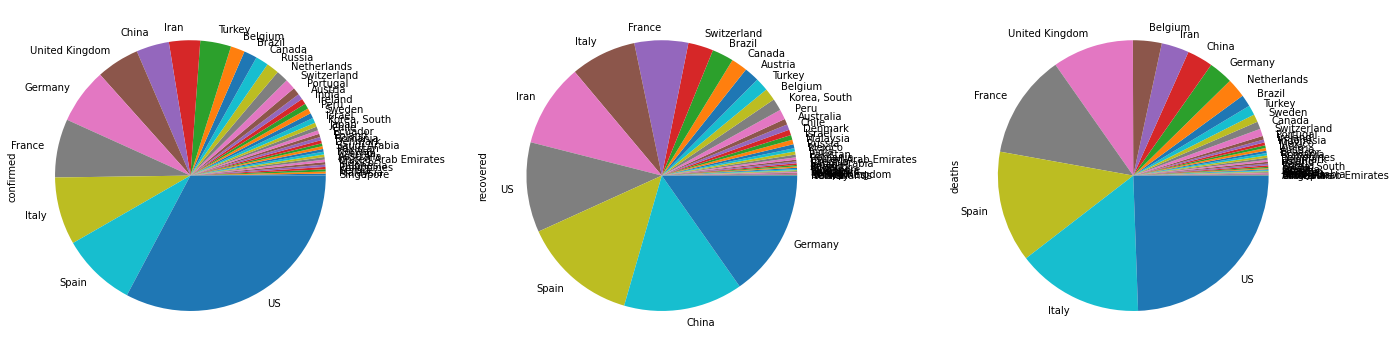

In [23]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
country_day_top = country_day[country_day['confirmed'] > min_confirmed]
country_day_top['confirmed'].sort_values().plot(kind='pie', ax = ax[0])#, figsize=(15,15))
country_day_top['recovered'].sort_values().plot(kind='pie', ax = ax[1])#, figsize=(15,15))
country_day_top['deaths'].sort_values().plot(kind='pie', ax = ax[2])#, figsize=(15,15))
plt.tight_layout()

In [24]:
country_day_top["confirmed"].count()

41

México está en esta gráfica justo en el traslape de países, con 5399 casos al 15 de abril de 20202.

In [25]:
country_day_top.loc["Mexico"]

confirmed    6297
recovered    2125
deaths        486
Name: Mexico, dtype: int64

## Número de países con números intermedios (*menos* de 5000 y más de 1000 casos confirmados):

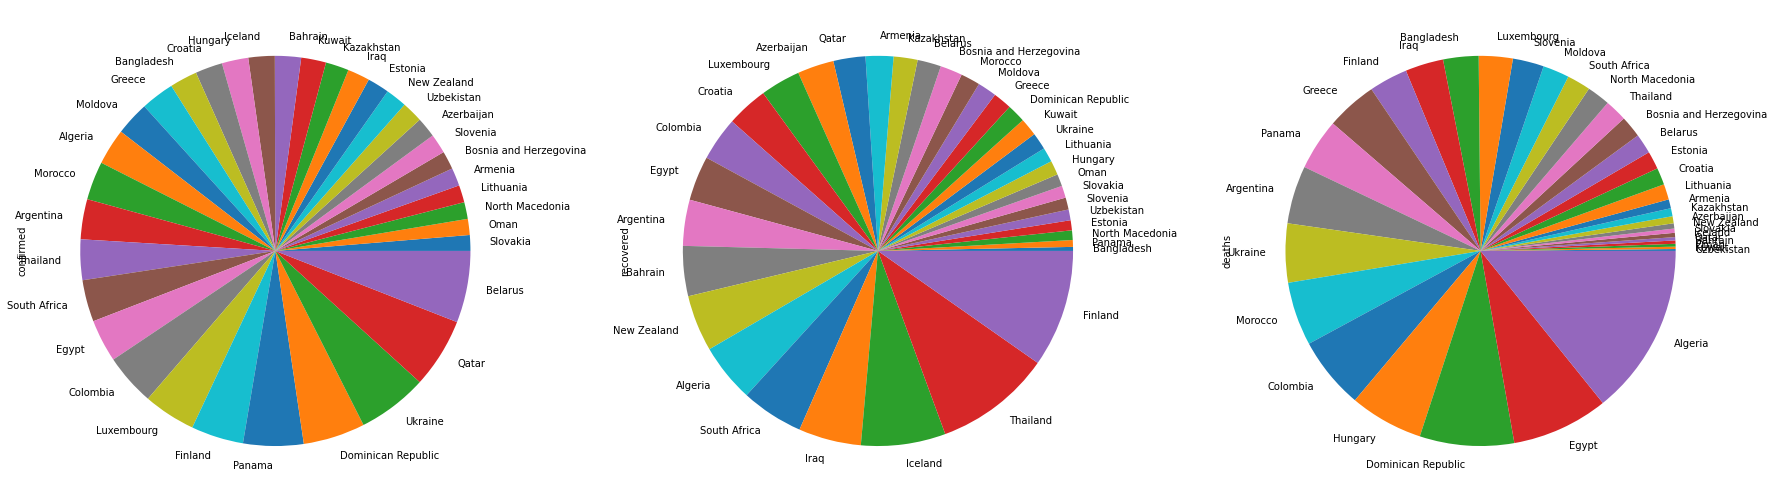

In [26]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
country_day_middle = country_day.query("confirmed <= 5000 & confirmed > 1000")
country_day_middle['confirmed'].sort_values().plot(kind='pie', ax = ax[0])
country_day_middle['recovered'].sort_values().plot(kind='pie', ax = ax[1])
country_day_middle['deaths'].sort_values().plot(kind='pie', ax = ax[2])
plt.tight_layout()

In [27]:
country_day_middle["confirmed"].count()

35

La distribución de casos confirmados es bastante uniforme, pero no las de casos recuperados y la de defunciones.

Creo que la diferencia de orden de los países en la primera y tercera gráfica debe tener mucho que ver con la cantidad de pruebas que se hacen, el único país que está en los primeros lugares en ambas gráficas es Japón.

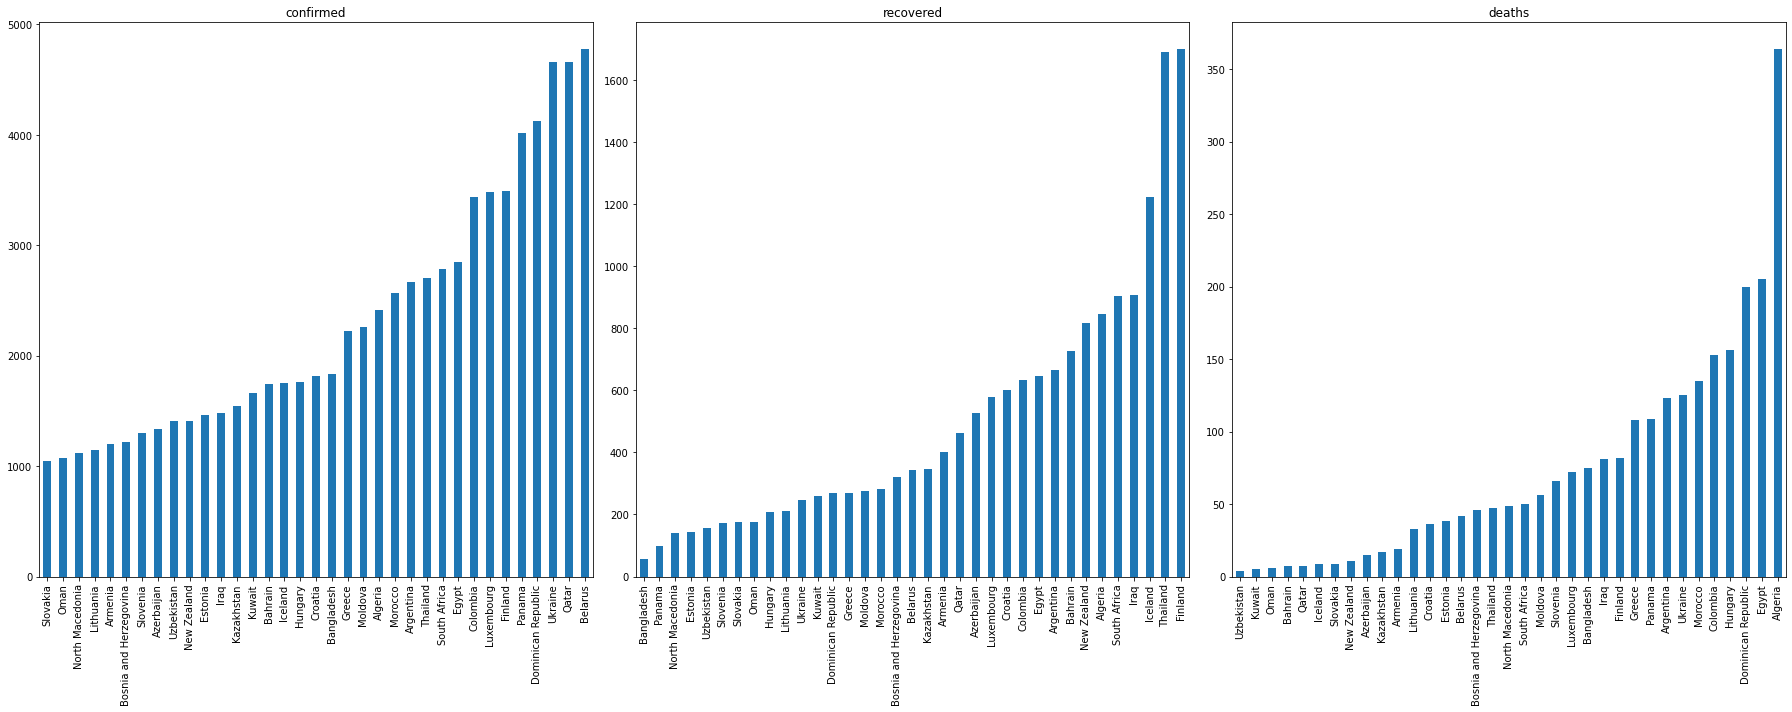

In [28]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
country_day_middle = country_day.query("confirmed <= 5000 & confirmed > 1000")
country_day_middle['confirmed'].sort_values().plot(kind='bar', ax = ax[0], title="confirmed")
country_day_middle['recovered'].sort_values().plot(kind='bar', ax = ax[1], title="recovered")
country_day_middle['deaths'].sort_values().plot(kind='bar', ax = ax[2], title="deaths")
plt.tight_layout()

## Número de países con pocos casos (Menor o igual a 1000):

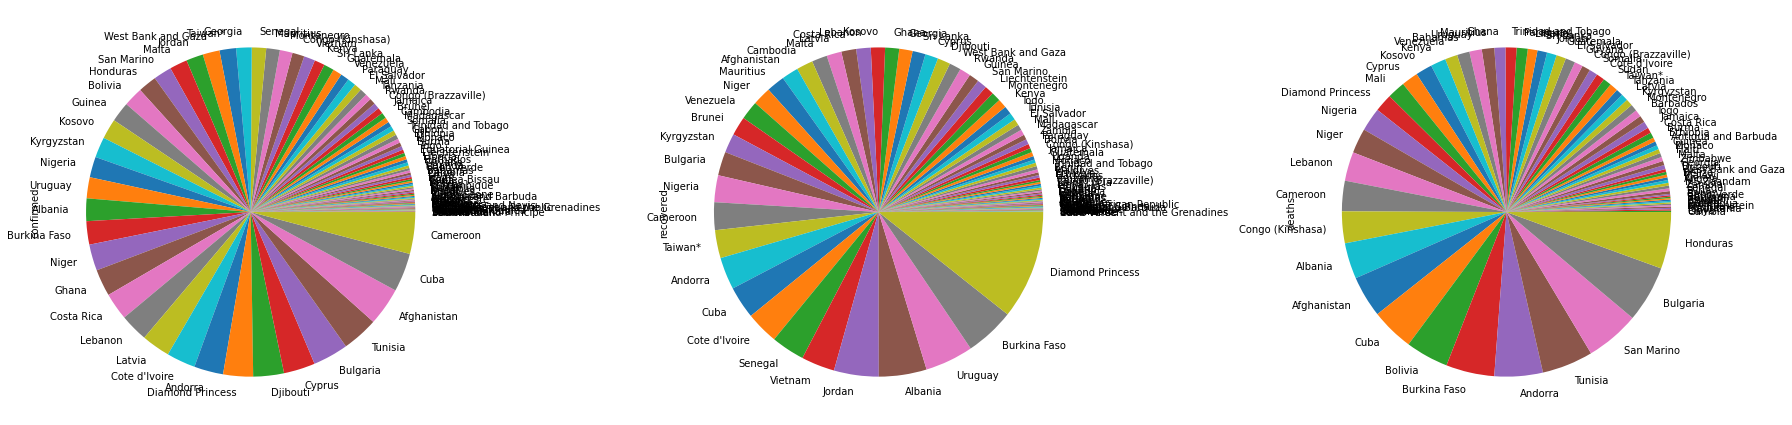

In [29]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
country_day_bottom = country_day.query("confirmed <= 1000")
country_day_bottom['confirmed'].sort_values().plot(kind='pie', ax = ax[0])
country_day_bottom['recovered'].sort_values().plot(kind='pie', ax = ax[1])
country_day_bottom['deaths'].sort_values().plot(kind='pie', ax = ax[2])
plt.tight_layout()

In [30]:
country_day_bottom["confirmed"].count()

109

## Distribución en histograma de número de países por número de casos
La distribución está muy centrada en valores por debajo de 1000 casos (ver tercer histograma, solo hay menos de 10 países que claramente entraron en una fase avanzada de casos. He visto comentarios de que se estima que podría infectarse el 70% de la población, por lo que deberíamos esperar que esa distribución se haga mucho más amplia con el paso de los meses.

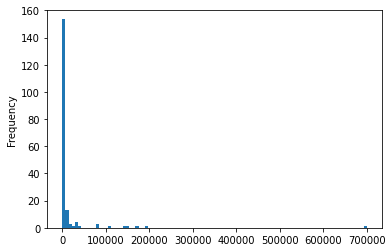

In [31]:
country_day["confirmed"].plot(kind="hist", bins=100, ylim=(0,160))

La distribución general básicamente no aporta información, la inmensa mayoría de los países van iniciando, yo esperaría que después de unos 3-6 meses la distribución esté centrada dentro de los 100 mil o más casos por país por lo menos. USA hace que la distrubición esté cada vez más extendida, pero la diferencia entre su número y el segundo lugar es enorme.

### Misma gráfica con menos divisiones

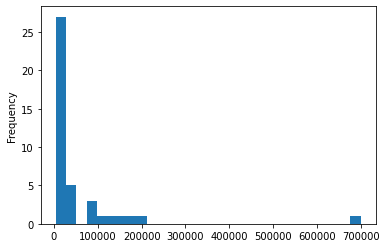

In [32]:
country_day_top["confirmed"].plot(kind="hist", bins=30)

Creo que ya es tiempo de remover USA de esta gráfica:

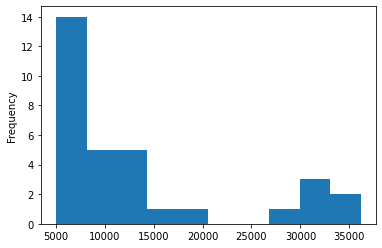

In [33]:
country_day_top.query("confirmed < 50000")["confirmed"].plot(kind="hist", bins=10)

Y sí, todavía nos falta para que esto se vea uniforme.

### Países con menos de 5000 casos y más de 1000

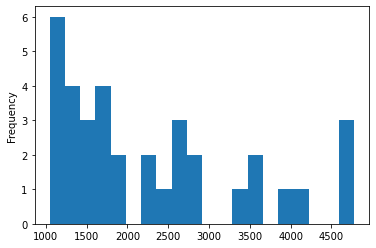

In [34]:
country_day_middle["confirmed"].plot(kind="hist", bins=20)

Que distribución tan extraña, obviamente el muestreo deja mucho que desear aquí.

### Países con menos de 1000 casos

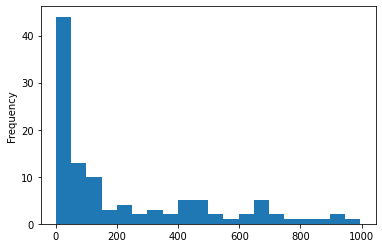

In [35]:
country_day_bottom["confirmed"].plot(kind="hist", bins=20)

Es claro que todavía la mayoría están iniciando, esos 40+ países que tienen menos de 50 casos definitivamente van a tener más casos en unos meses.

# Número de casos como línea de tiempo por grupos de países

La siguiente función devuelve 4 gráficas de línea de tiempo para la lista de países con los números de enfermos confirmados, un estimado del número de casos activos, una de decesos registrados y una de porcentaje de decesos con respecto a los detectados. Acepta un argumento que es la lista de nombres de países que se quiere graficar.

In [36]:
def plot_timeline(c_list = ["Mexico"], figsize=(15,5)):
    fig, ax = plt.subplots(1,4, figsize=figsize)
    plt.xticks(rotation=45)
    for c in c_list:
        ax[0].plot(country[c]["2020-01":]["confirmed"], label=c)
        ax[1].plot(country[c]["2020-01":]["confirmed"] - 
                   country[c]["2020-01":]["recovered"] - 
                   country[c]["2020-01":]["deaths"], label=c)
        ax[2].plot(country[c]["2020-01":]["deaths"], label=c, linestyle="-")
        ax[3].plot(country[c]["2020-01":]["deaths"]/country[c]["2020-01":]["confirmed"]*100, label=c, linestyle="-")
        
        ax[0].set_title("Confirmed")
        ax[1].set_title("Active")
        ax[2].set_title("Deaths")
        ax[3].set_title("% of deaths")
    if ax[3].set_ylim()[1] > 20: # fix for Iran % of deaths plot.
        ax[3].set_ylim([-1, 20])
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
        plt.legend()

## Mexico / Korea del Sur / Singapur / Suecia / Rep. Checa / Suiza
Países que me interesan por su contexto parecido al de México y la esperanza de que tengamos resultados positivos (a diferencia de la mayoría de los países del Top 10, por ejemplo).

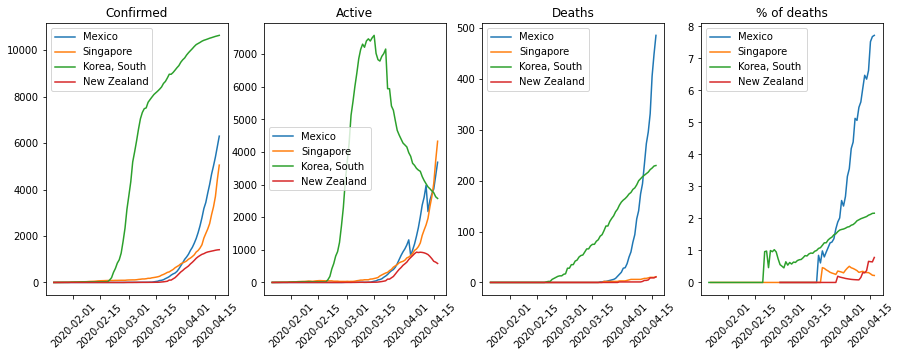

In [37]:
c_list = ["Mexico","Singapore", 
          "Korea, South", 
          "New Zealand"]
plot_timeline(c_list)

Corea claramente hizo lo necesario para su contexto. Nueva Zenanda parece ir por un camino aún mejor, pero es temprano para estar seguros. Singapur pudo mantenerse con números bajos mucho tiempo, y sigue teniendo un número de decesos muy bajo, aunque los casos confirmados son similares a los de México que poco a poco (y muy rápido en las últimas 4 semanas) ha ido aumentando el número de casos y decesos, al grado de que casi tenemos 8% de decesos, es un número bastante preocupante. 

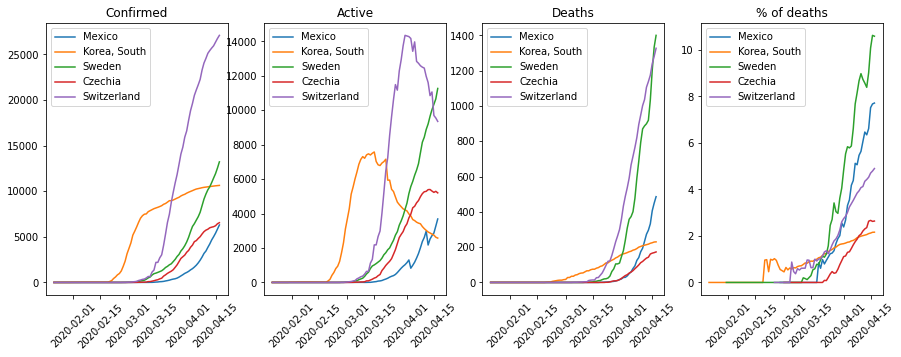

In [38]:
c_list = ["Mexico", "Korea, South", "Sweden", "Czechia", "Switzerland",]
plot_timeline(c_list)

Rep. Checa es otro país mencionado como buen manejador de la epidemia, al momento pareciera que va a llevar un comportamiento similar a Suecia, en el que la confianza al principio mantiene las cosas tranquilas, pero al momento de entrar a fase 2 hay que reaccionar activamente muy rápido y dejar atrás los intentos de mantener todo normal.

Pareciera que Rep. Checa está logrando aplanar la curva, todavía podrían mantenerse en números relativamente bajos.

México desafortunadamente lleva un comportamiento bastante similar al de Suecia y Suiza, esto es algo que debería tomarse en cuenta para apretar las medidas de contención, no veo cómo podamos levantar la cuarentena en 1 o 2 meses con este comportamiento, me parece bastante plausible que tengamos que mantenernos en distanciamiento social de 4 a 6 meses. Veamos en los próximos meses si mejora esto.

## Tabla de diferencias (nuevos casos) para México

In [39]:
country["Mexico"].diff()

,confirmed,deaths,recovered
date,,,
2020-01-22,NaN,NaN,NaN
2020-01-23,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0
...,...,...,...
2020-04-13,442.0,23.0,71.0
2020-04-14,353.0,36.0,121.0
2020-04-15,385.0,74.0,161.0


Tenemos ya más de 400 casos nuevos al día, y 40 muertos, en números totales México tiene ya el 6% de decesos con respecto a los casos comprobados, ambos números son aproximados, sabemos incluso por la apreciación oficial que estos números no son necesariamente cercanos a los reales, pero aún así es algo preocupante que el número de muertes nuevas por día sigue aumentando.

Y al parecer sí vamos aplanando la curva también, las gráficas correspondientes se ven así:

<!-- Las cosas se ven mal en este momento, tenemos 202 nuevos casos y 19 decesos, no es que sea totalmente correcto comparar así pero a este paso vamos a llegar al 10% de decesos comparado contra los detectados totales. En el siguiente grupo de gráficas vemos que Italia, Alemania y Francia andan sobre 10%, así que desafortunadamente no suena descabellado que países como México lleguen a esos números en cuestión de decesos. -->

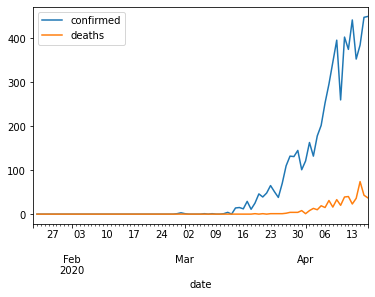

In [40]:
country["Mexico"].diff()[["confirmed","deaths"]].plot()

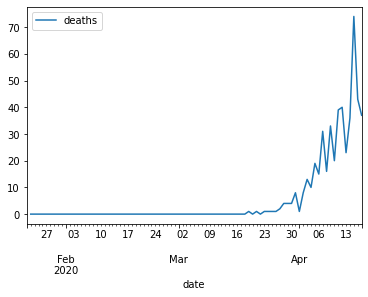

In [41]:
country["Mexico"].diff()[["deaths"]].plot()

## Países  en el top 5 de casos confirmados
Podemos crear listas manualmente, pero para estos casos simplemente podemos usar el DataFrame que tenemos para el último día registrado y de ahí sacar las listas interesantes automáticamente.

In [42]:
c_list = country_day.sort_values("confirmed", ascending=False).head(5).index
c_list

Index(['US', 'Spain', 'Italy', 'France', 'Germany'], dtype='object')

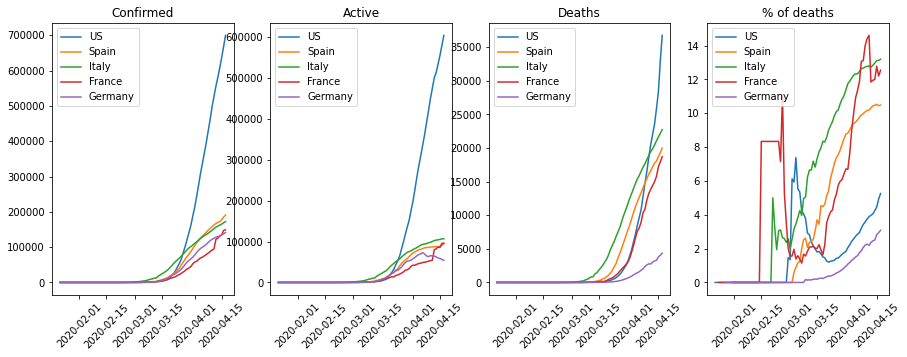

In [43]:
plot_timeline(c_list)

Se podrá decir mucho de China pero es bastante obvio que sus métodos de contención funcionan, ya no está en los primeros 5 países con más casos detectados. Los otros 5 países con más casos en este momento son de primer mundo. Alemania pareciera ser que sí está logrando contener el brote, podría incluso estar entrando en tercera fase pronto (una de crecimiento lineal).

USA ya superó a Italia en número de muertos, y tiene una cantidad de casos confirmados mucho mayor que los otros países en la lista, y mantiene un porcentaje de decesos más bajo que 4 de los 5 países, posiblemente atribuíble a que hacen muchas más pruebas que los otros países y tienen más población que ellos también.

El movimiento en % de decesos puede interpretarse como el nivel de control que tiene cada país sobre la epidemia, y al parecer solo China (del top 10) es el que lo ha logrado en estos países, Alemania podría estar cerca de lograrlo también, los demás países siguen en fase dos con crecimientos exponenciales muy marcados.

## Países en el top 6-10 de casos confirmados

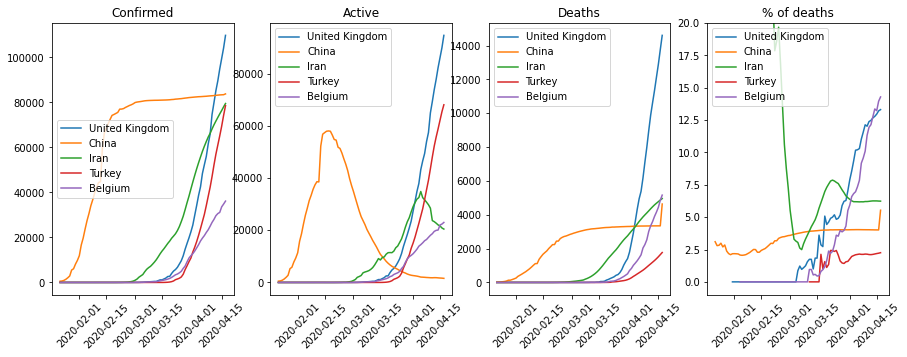

In [44]:
c_list = country_day.sort_values("confirmed", ascending=False).head(10).tail(5).index
plot_timeline(c_list)

La otra mitad del top 10 tampoco se ve bien. Irán me obligó a aplicar un límite condicional en el eje Y ya que sus números empiezan con 100% de decesos, lo cual arruina por completo la visualización del resto de los países.

Irán pareceiera que ya empezó a aplanar su curva, simiar a la gráfica global, pero apenas empieza. Turquía tiene muchos casos confirmados pero su porcentaje de decesos está abajo de 2.5% lo cual es muy bueno.

## Countries in the top 11-20 confirmed list

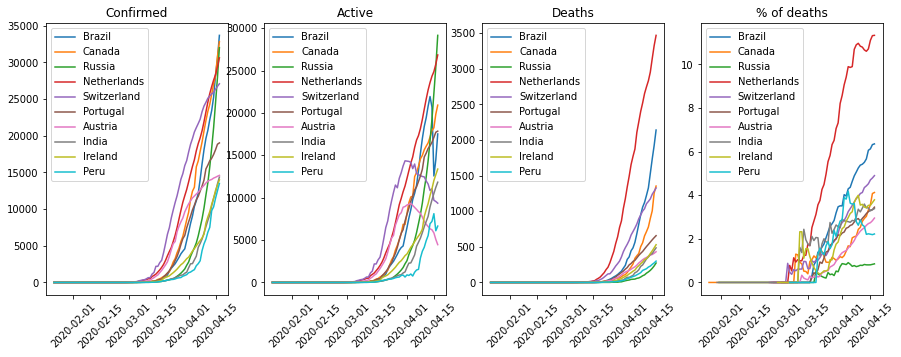

In [45]:
c_list = country_day.sort_values("confirmed", ascending=False).head(20).tail(10).index
plot_timeline(c_list)

Del este grupo Corea del Sur es el único que parece haber superado la etapa difícil (¿la primera?) los demás países parecen apenas ir iniciando algunos de ellos podrían todavía tener números similares a Korea si usan las medidas pertinentes para cada caso, habrá que ver cómo evoluciona esto (hoy es 29 de Marzo del 2020).

Israel e Irlanda parecen tener controlado el numero de decesos, los demás países no realmente.

## Países con entre 500 y 1000 casos
Hay una distribución amplia de números, pero en general todos van sobre un comportamiento similar, exceptuando el barco "Diamond Princess" que veremos abajo.

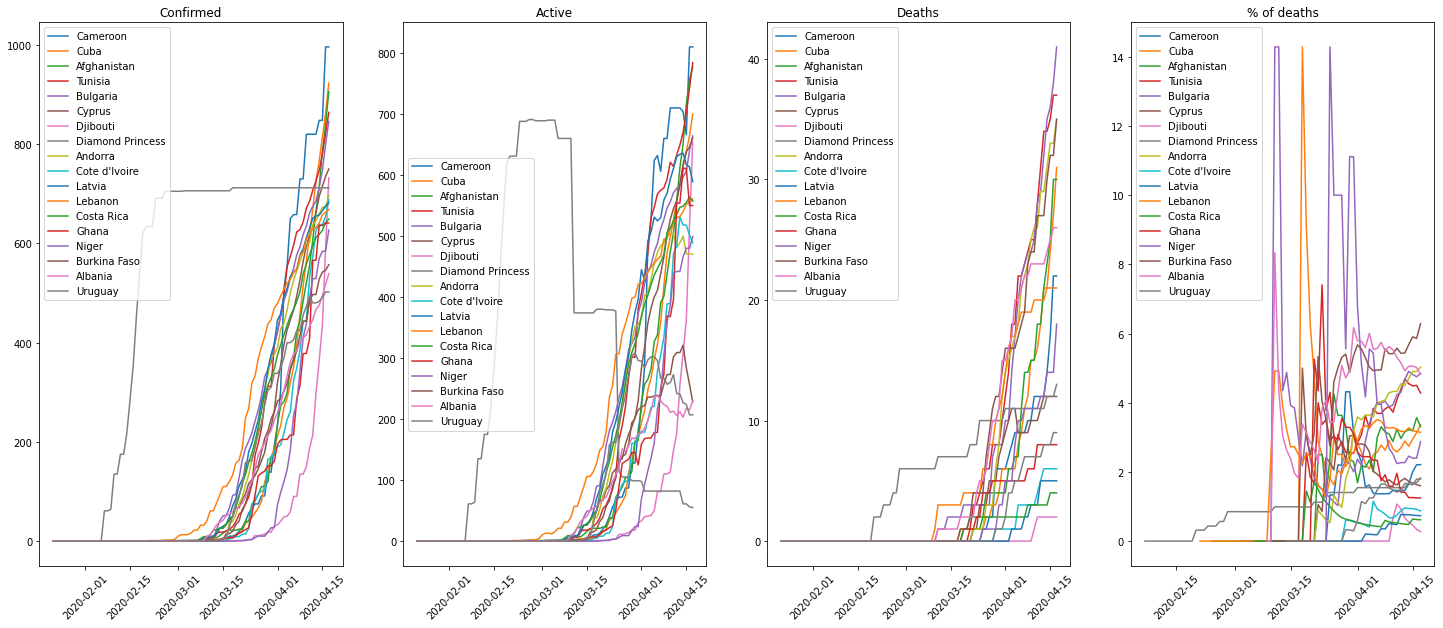

In [46]:
c_list = country_day.query("confirmed > 500 & confirmed < 1000 ").sort_values("confirmed", ascending=False).index
plot_timeline(c_list, figsize=(25,10))

## Diamond Princess 

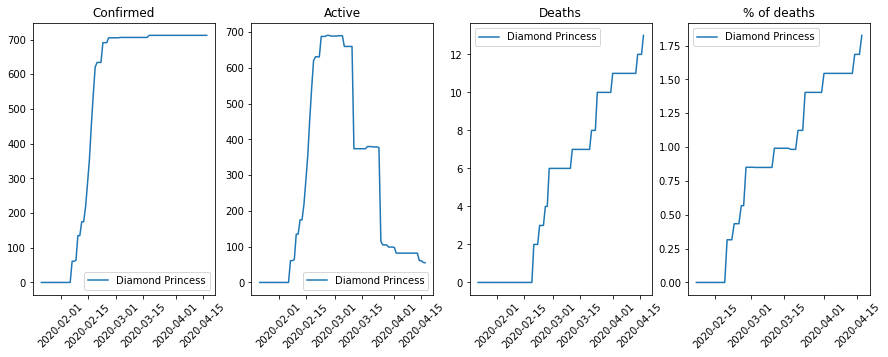

In [47]:
plot_timeline(["Diamond Princess"])

Parece ser que el problema ya está controlado en el crucero, al parecer todavía no empiezan a desembarcar a las personas, pero con 100 casos todavía activos es probable que les tome un poco más de tiempo. México tiene un índice de mortalidad similar al inicio de la fase 2, esperemos que así continúe.

# Datos del país normalizados al día-cero 
Hoy 2020-04-05 voy a mover la normaización al primer día con más de 499 casos, y en unos días más lo moveré a 1000 para empezar a ver números más "estables" y mejores ajustes ahora que hemos avanzado unas semanas más los países que apenas vamos en las primeras semanas de crisis.

In [48]:
def get_country(data, country='Mexico', min_cases=499, column="confirmed"):
    data_df = pd.DataFrame(data.json()[country],)
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df = data_df[data_df["confirmed"] > min_cases ]
    min_sec = time.mktime(data_df['date'].min().timetuple())
    data_df['seconds'] = [time.mktime(t.timetuple()) - min_sec for t in data_df.date]
    data_df['days'] = data_df['seconds'] / 86400
    return data_df[["days", column]].set_index("days")

In [49]:
# Example: Mexico data
mx = get_country(data, country='Mexico')
mx.head()

,confirmed
days,
0.0,585
1.0,717
2.0,848
3.0,993
4.0,1094


## Uniendo dataframes normalizados para la lista de países deseada

In [50]:
def merge_country(data, suffixes=["_mx", "_ks"], c_list=["Mexico", "Korea, South"], column="confirmed"):
    if len(c_list) != len(suffixes):
        raise "Both c_list and suffixes need to have same length"
    df = get_country(data, country=c_list.pop(0), column=column)
    s = suffixes.pop(0)
    for i in range(len(c_list)):
        df = pd.merge(df, get_country(data, country=c_list[i], column=column), how="outer", suffixes=[s, suffixes[i]], on="days") #first two
        df.rename(columns={column: "{}{}".format(column, suffixes[i])}, inplace=True) # Rest of them
    return df    

## Comparando México con Corea del Sur y Suecia

Son los dos países que se ponen como ejemplo en las noticias, Suecia parece que de pronto saltó de ser el ejemplo a no serlo, pero lo veremos más claro en unos días.

Eliminé a USA porque es el primer lugar mundial en casos y solo hace ruido en la gráfica. Por razones similares quito España, Francia e Italia, los veremos en un subgrupo aparte, ya están muy lejos del comportamiento de México que es el que más me interesa ver.

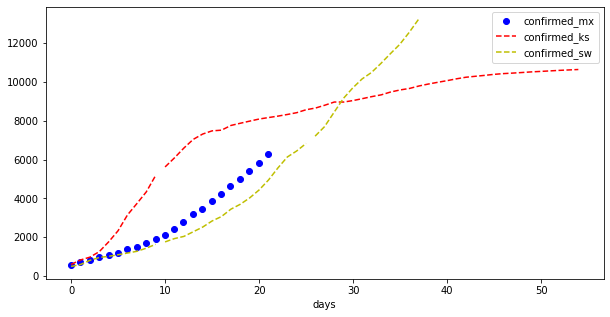

In [51]:
s = ["_mx"    , "_ks"         , "_sw"]
cl = ["Mexico", "Korea, South", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,15), ylim=(0,5000))

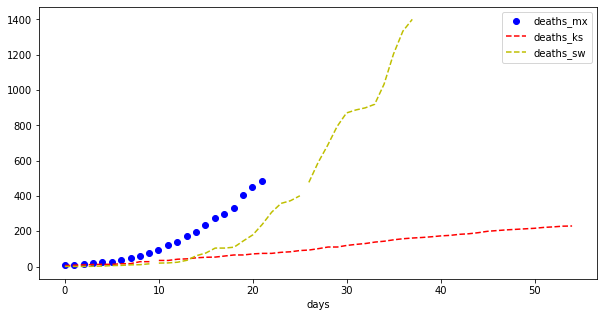

In [52]:
s = ["_mx"    , "_ks"         , "_sw"]
cl = ["Mexico", "Korea, South", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

## Agregando Singapur y Rep. Checa como buen ejemplo

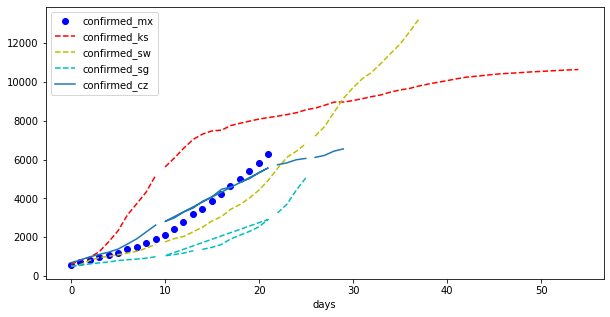

In [53]:
s = ["_mx"    , "_ks"         , "_sw"   , "_sg"      , "_cz"]
cl = ["Mexico", "Korea, South", "Sweden", "Singapore", "Czechia"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

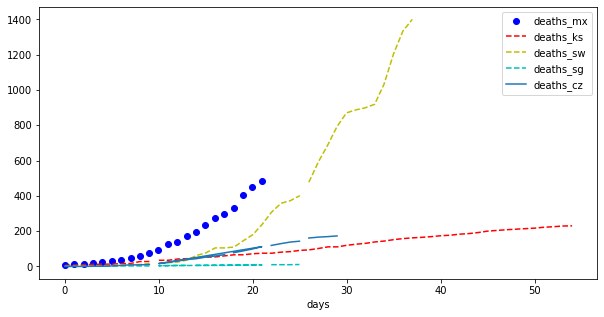

In [54]:
s = ["_mx"    , "_ks"         , "_sw"   , "_sg"      , "_cz"]
cl = ["Mexico", "Korea, South", "Sweden", "Singapore", "Czechia"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

Definitivamente Singapur va muy bien, ha logrado estar más de 2 meses sin pasar a fase 2. Suecia estuvo cerca pero no lo logró, Corea del Sur tuvo 1 mes en fase 1, y México solo 20-25 días, y el último agregado Rep. Checa tuvo también unos 20 días de fase 1 y ahora va más rápido que México, aunque con menos decesos.

Nota: México aparentemente está haciendo pocas pruebas de tal manera que sus números confirmados seguramente son bastante menores de los reales, pero el número de muertes por Covid-19 es mucho más confiable, es algo a considerarse en el análisis de los datos oficiales. Estoy seguro que no somos el único país en esa situación, por lo que el error más o menos se elimina en las comparaciones.

## Otra conjunto de países "interesantes"
Los he visto muy mencionados en noticias, seguro en los próximos días y semanas se moverán mucho los países más mencionados al respecto del covid-19. 

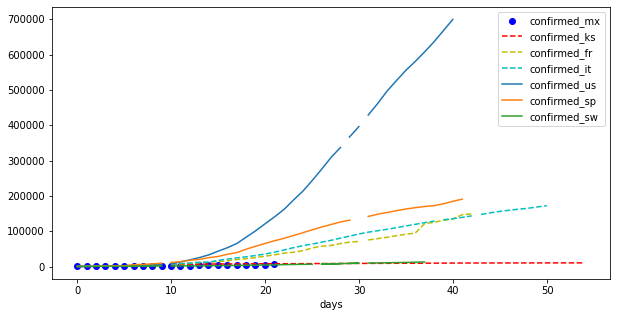

In [55]:
s = ["_mx"    , "_ks"         , "_fr"   , "_it"  , "_us", "_sp"  , "_sw"]
cl = ["Mexico", "Korea, South", "France", "Italy", "US", "Spain", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
#display(cgroup.tail())
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

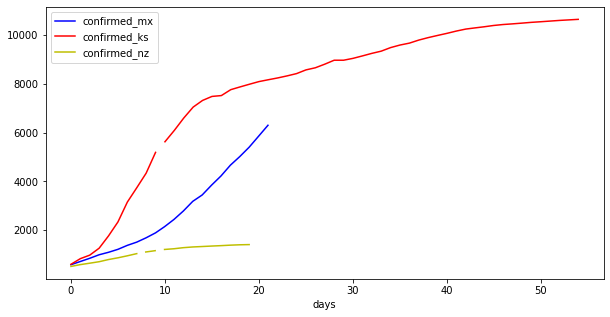

In [56]:
s = ["_mx"    , "_ks"         , "_nz"]
cl = ["Mexico", "Korea, South", "New Zealand"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
#display(cgroup.tail())
cgroup.plot(figsize=(10,5), style = ['b-','r-','y-', 'c-'])#, xlim=(0,35), ylim=(0,1000))

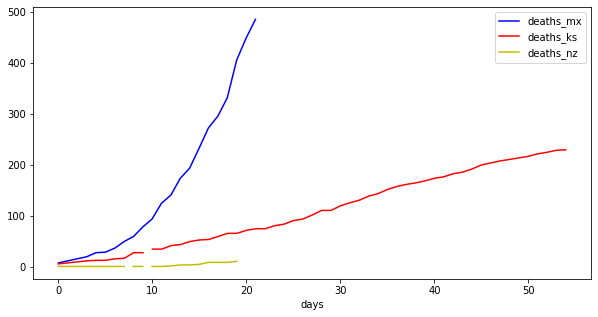

In [57]:
s = ["_mx"    , "_ks"         , "_nz"]
cl = ["Mexico", "Korea, South", "New Zealand"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
#display(cgroup.tail())
cgroup.plot(figsize=(10,5), style = ['b-','r-','y-', 'c-'])#, xlim=(0,35), ylim=(0,1000))

## Revisando China por las últimas noticias de que hay repunte de casos

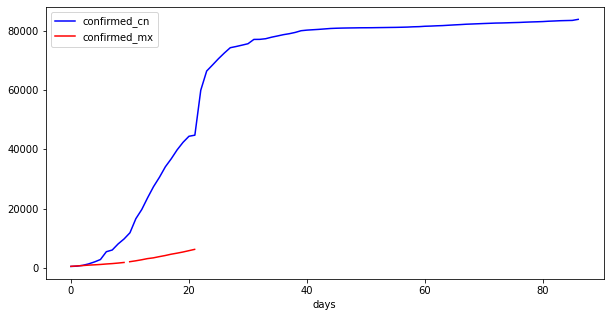

In [58]:
s = ["_cn", "_mx"]
cl = ["China", "Mexico"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['b-','r-','y-', 'c-'])#, xlim=(0,35), ylim=(0,1000))

In [59]:
cgroup.diff(periods=1).head(20)

,confirmed_cn,confirmed_mx
days,,
0.0,NaN,NaN
1.0,95.0,132.0
2.0,277.0,131.0
3.0,486.0,145.0
4.0,669.0,101.0
5.0,802.0,121.0
6.0,2632.0,163.0
7.0,578.0,132.0
8.0,2054.0,178.0


In [60]:
cgroup.diff().tail()

,confirmed_cn,confirmed_mx
days,,
16.958333,NaN,442.0
17.958333,NaN,353.0
18.958333,NaN,385.0
19.958333,NaN,448.0
20.958333,NaN,450.0


Podemos ver que aunque ha tenido pequeños brotes, México tiene más casos nuevos en los últimos días (el desfase es por la "normalización" al día cero). Suena muy razonable atender menos de 100 casos nuevo al día, si mantienen ese comportamiento las cosas van a evolucionar bastante aceptablemente en China.

# Predicción para México (u otro país, cambia la etiqueta)
Usando las mismas rutinas de antes podemos sacar fácilmente predicciones por país, vamos a crear una función que nos devuelva las gráficas de ajuste exponencial y polinomial para un país.

In [61]:
def plot_polyfit(data, order=4, column="confirmed", days_plus=10):
    p = np.polyfit(data.index.array, data[column].array,order)
    x = np.linspace(data.index.min(), data.index.max(),50)
    f = np.poly1d(p)
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    data['poly'] = f(data.index)
    data.plot(y=[column, "poly"], fig=fig, ax = ax1)
    x = np.linspace(data.index.min(), data.index.max()+days_plus,20)
    ax2.plot(x, f(x))
    x, f(x)
    fig.suptitle("Ajuste polinomial a {}o orden".format(order))

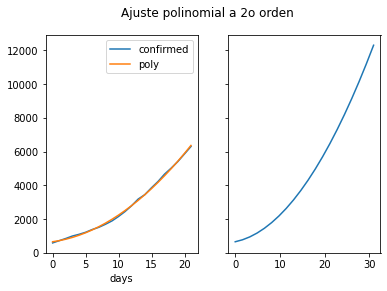

In [62]:
mex = get_country(data, country="Mexico", column="confirmed") # by default returns Mexico
plot_polyfit(mex, column="confirmed", order=2)

Con la normalización a partir de más de 499 casos el comportamiento de México es casi lineal como es de esperarse en la etapa 2. Aproximadamente cada 10 días vamos a tener el doble de casos mientras sigamos con este comportamiento.

In [63]:
def plot_expfit(data, days_plus=5, column="confirmed"):
    x_range = data.index
    y_range = np.log(data[column])

    X = sm.add_constant(x_range)
    y = y_range
    mods = sm.OLS(y, X)

    res = mods.fit()

    a, b = res.params
    y = lambda x: np.exp(a) * np.exp(b) ** x
    x_future = np.linspace(data.index.min(), data.index.max()+days_plus, 20)
    
    plt.plot(x_future, y(x_future), 'r-')
    plt.plot(data.index, data[column], 'b-')
    plt.title("Ajuste exponencial\n(extendido {} días en el futuro)".format(days_plus))

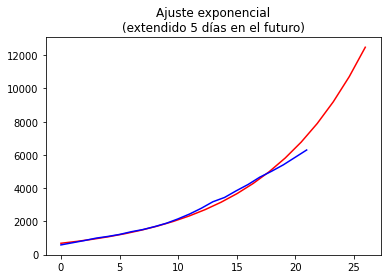

In [64]:
plot_expfit(mex)

Y durante un tiempo el ajuste exponencial va a ser algo malo, aunque creo que mejor que al tomar dia cero a partir del primer caso detectado.

# Playground

In [65]:
other = get_country(data, country="Czechia", column="confirmed") # by default returns Mexico
#plot_polyfit(other)
#other.diff()

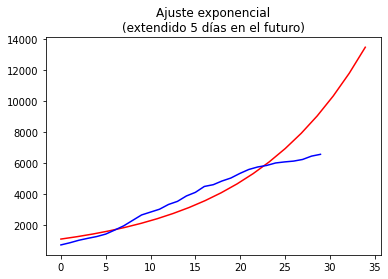

In [66]:
plot_expfit(other)

Terrible ajuste para Rep. Checa.

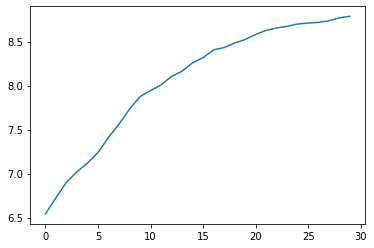

In [67]:
plt.plot(other.index, np.log(other["confirmed"]))

Esta es la razón por la que el ajuste es malo, no va nada lineal la curva logarítmica.

In [68]:
us = get_country(data, country="US", column="deaths", min_cases=1) # by default returns Mexico
#us = us[us["deaths"] > 0]
#plot_polyfit(us, column="deaths", days_plus=4,order=4)

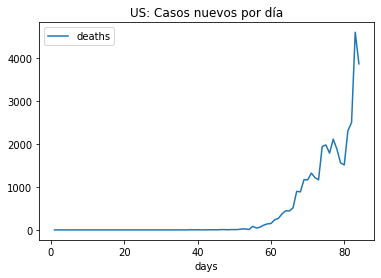

In [69]:
us.diff().plot(title="US: Casos nuevos por día")

In [70]:
mx = get_country(data, country="Mexico", column="deaths", min_cases=1) # by default returns Mexico`

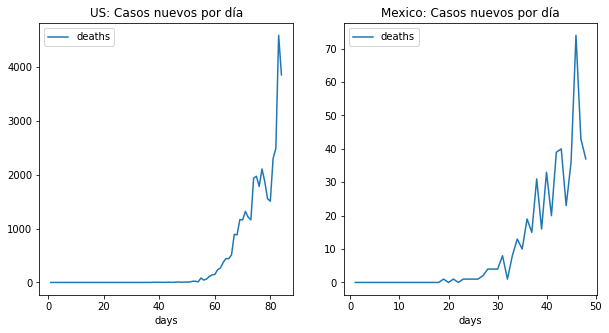

In [71]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
us.diff().plot(title="US: Casos nuevos por día", ax=ax[0])
mx.diff().plot(title="Mexico: Casos nuevos por día", ax=ax[1])

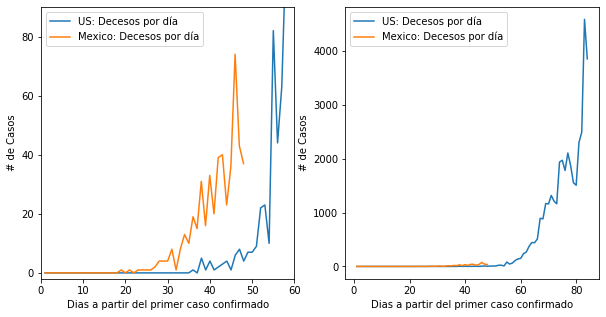

In [72]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(us.diff(), label="US: Decesos por día")
ax[0].plot(mx.diff(), label="Mexico: Decesos por día")
#plt.legend()
ax[0].set_xlim([0,60])
ax[0].set_ylim([-2,90])

ax[1].plot(us.diff(), label="US: Decesos por día")
ax[1].plot(mx.diff(), label="Mexico: Decesos por día")
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.ylabel("# de Casos")
    plt.xlabel("Dias a partir del primer caso confirmado")
    plt.legend()

A la izq. tenemos un acercamiento de la zona comparable de México con respecto a USA, la segunda es la gráfica completa, vemos que México va "por encima" en decesos, por unos días parecía que se estaba aplanando esta gráfica, pero hoy 15 de abril de 2020 dío un salgo grande con casi 80 nuevos casos, prácticamente el doble de los días anteriores.